# Dependencias

In [1]:
# PyTorch con Soporte CUDA
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [2]:
# Instalando dependencias
!pip install --user pyarrow findspark pyspark tensorflow pandas scikit-learn ydata-profiling matplotlib numpy seaborn opencv-python pillow pydicom scikit-image lime tf-keras-vis numpy xgboost grad-cam easyocr==1.7.2 joblib


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Inicializacion

In [3]:
%matplotlib inline

In [4]:
import sys
from pathlib import Path

# Force add the project root to sys.path (adjust as needed)
project_root = Path("../").resolve()  # one level up from /notebooks/
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [5]:
# Calculos
import numpy as np
import pandas as pd

# PyTorch
import torch

# Visualizacion
from ydata_profiling import ProfileReport

# Utilidades
import os
import re

## Constantes

In [6]:
DATA_ABS_PATH                   = os.path.abspath("../data/CBIS-DDSM")
IMAGES_ABS_PATH                 = os.path.abspath("../data/CBIS-DDSM/CBIS-DDSM")
CLEANED_IMAGES_ABS_PATH         = os.path.abspath("../data/CBIS-DDSM/CLEANED-CBIS-DDSM") # Same as above but in .pgn
TEXT_CLEANED_IMAGES_ABS_PATH    = os.path.abspath("../data/CBIS-DDSM/TEXT-CLEANED-CBIS-DDSM") # Same as above but with text and white borders removed
MASS_CASE_DESCRIPTION_TRAIN_SET = DATA_ABS_PATH + '/mass_case_description_train_set.csv'
MASS_CASE_DESCRIPTION_TEST_SET  = DATA_ABS_PATH + '/mass_case_description_test_set.csv'
CALC_CASE_DESCRIPTION_TRAIN_SET = DATA_ABS_PATH + '/calc_case_description_train_set.csv'
CALC_CASE_DESCRIPTION_TEST_SET  = DATA_ABS_PATH + '/calc_case_description_test_set.csv'
METADATA_CSV                    = DATA_ABS_PATH + '/metadata.csv'

CBISDDSM_DF                     = DATA_ABS_PATH + '/meta/CBIS-DDSM.parquet'
CBISDDSM_FIXED_SET              = DATA_ABS_PATH + '/meta/CBIS-DDSM-fixed.parquet'
OUTPUT_TRAIN                    = DATA_ABS_PATH + '/meta/train_split.parquet'
OUTPUT_VAL                      = DATA_ABS_PATH + '/meta/val_split.parquet'
OUTPUT_TEST                     = DATA_ABS_PATH + '/meta/test_split.parquet'

FEATURES_OUTPUT_PATH            = os.path.abspath("../models/output/features/")
MODELS_OUTPUT_PATH              = os.path.abspath("../models/output/")
MODELS_LOGS_OUTPUT_PATH         = os.path.abspath("../models/logs/")

SKIP_TRAINING                   = False
INFERENCE_OUTPUT                = os.path.abspath("../output")

LABEL_MAP = {
    "BENIGN": 0,
    "BENIGN_WITHOUT_CALLBACK": 1, # Benigno sin necesidad de mas estudios
    "MALIGNANT": 2
}

## Sesion de Spark

In [7]:
import findspark

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, BooleanType


findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark = SparkSession.builder.appName("breast_cancer_detection").master("local[*]").getOrCreate()
sqlCtx = SQLContext(sparkContext=spark.sparkContext, sparkSession=spark)
spark

### Creacion de DataFrames

In [8]:
metadata_df = spark.read.csv(METADATA_CSV, header=True)
metadata_df.describe()

DataFrame[summary: string, Series UID: string, Collection: string, 3rd Party Analysis: string, Data Description URI: string, Subject ID: string, Study UID: string, Study Description: string, Study Date: string, Series Description: string, Manufacturer: string, Modality: string, SOP Class Name: string, SOP Class UID: string, Number of Images: string, File Size: string, File Size float: string, File Location: string, Download Timestamp: string]

In [9]:
mass_train_df = spark.read.csv(MASS_CASE_DESCRIPTION_TRAIN_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
mass_train_df.describe()

DataFrame[summary: string, patient_id: string, breast_density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, mass shape: string, mass margins: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

In [10]:
mass_test_df = spark.read.csv(MASS_CASE_DESCRIPTION_TEST_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
mass_test_df.describe()

DataFrame[summary: string, patient_id: string, breast_density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, mass shape: string, mass margins: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

In [11]:
calc_train_df = spark.read.csv(CALC_CASE_DESCRIPTION_TRAIN_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
calc_train_df.describe()

DataFrame[summary: string, patient_id: string, breast density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, calc type: string, calc distribution: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

In [12]:
calc_test_df = spark.read.csv(CALC_CASE_DESCRIPTION_TEST_SET, header=True, inferSchema=True, multiLine=True, quote='"', escape='"')
calc_test_df.describe()

DataFrame[summary: string, patient_id: string, breast density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, calc type: string, calc distribution: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string]

**Nota**: Hay algunas columnas que tienen caracteres especiales, como saltos de linea. Como la columna con la direccion del ROI:

In [13]:
calc_test_df.show(2, truncate=False)

+----------+--------------+--------------------+----------+--------------+----------------+--------------------+-----------------+----------+---------+--------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|patient_id|breast density|left or right breast|image view|abnormality id|abnormality type|calc type           |calc distribution|assessment|pathology|subtlety|image file path                                                                                                                                                        |cro

Ahora reemplazare los nombres erroneos de las imagenes (000000.dcm) por su nombre real, segun el siguiente patron:

- **image file path**: Aparece con nombre de archivo 000000.dcm, pero todas se llama 1-1.dcm
- **cropped image file path**: Aparece con nombre de archivo 000000.dcm, pero todas se llaman 1-1.dcm y se encuentran en las carpetas con el sufijo _1 (ejemplo: CC_1, MLO_1, etc.)
- **ROI mak file path**: Aparece con nombre de archivo 000000.dcm, pero todas se llaman 1-2.dcm y se encuentra en las carpetas con el sufijo _1

In [14]:
mass_train_df = mass_train_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("type", F.lit("mass"))

In [15]:
mass_test_df = mass_test_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-2.dcm")) \
                .withColumn("type", F.lit("mass"))

In [16]:
calc_train_df = calc_train_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-2.dcm")) \
                .withColumn("type", F.lit("calc")) \
                .withColumnRenamed("breast density", "breast_density")

In [17]:
calc_test_df = calc_test_df \
                .withColumn("image_path", F.regexp_replace("image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("cropped_path", F.regexp_replace("cropped image file path", r"/[^/]+$", "/1-1.dcm")) \
                .withColumn("roi_path", F.regexp_replace("ROI mask file path", r"/[^/]+$", "/1-2.dcm")) \
                .withColumn("type", F.lit("calc")) \
                .withColumnRenamed("breast density", "breast_density")

In [18]:
mass_train_df.filter(F.col('image_path').isNotNull()).count()

1318

In [19]:
mass_train_df.select(F.col('patient_id')).show(5, truncate=False)

+----------+
|patient_id|
+----------+
|P_00001   |
|P_00001   |
|P_00004   |
|P_00004   |
|P_00004   |
+----------+
only showing top 5 rows



In [20]:
print('mass_train_df image_path null count:', mass_train_df.filter(F.col('image_path').isNotNull()).count())
print('mass_train_df cropped_path null count:', mass_train_df.filter(F.col('cropped_path').isNotNull()).count())
print('mass_train_df roi_path null count:', mass_train_df.filter(F.col('roi_path').isNotNull()).count())
print()
print('mass_test_df image_path null count:', mass_test_df.filter(F.col('image_path').isNotNull()).count())
print('mass_test_df cropped_path null count:', mass_test_df.filter(F.col('cropped_path').isNotNull()).count())
print('mass_test_df roi_path null count:', mass_test_df.filter(F.col('roi_path').isNotNull()).count())
print()
print('calc_train_df image_path null count:', calc_train_df.filter(F.col('image_path').isNotNull()).count())
print('calc_train_df cropped_path null count:', calc_train_df.filter(F.col('cropped_path').isNotNull()).count())
print('calc_train_df roi_path null count:', calc_train_df.filter(F.col('roi_path').isNotNull()).count())
print()
print('calc_test_df cropped_path null count:', calc_test_df.filter(F.col('cropped_path').isNotNull()).count())
print('calc_test_df image_path null count:', calc_test_df.filter(F.col('image_path').isNotNull()).count())
print('calc_test_df roi_path null count:', calc_test_df.filter(F.col('roi_path').isNotNull()).count())

mass_train_df image_path null count: 1318
mass_train_df cropped_path null count: 1318
mass_train_df roi_path null count: 1318

mass_test_df image_path null count: 378
mass_test_df cropped_path null count: 378
mass_test_df roi_path null count: 378

calc_train_df image_path null count: 1546
calc_train_df cropped_path null count: 1546
calc_train_df roi_path null count: 1546

calc_test_df cropped_path null count: 326
calc_test_df image_path null count: 326
calc_test_df roi_path null count: 326


In [21]:
mass_train_df.filter(F.col('cropped_path').isNotNull()).count()

1318

In [22]:
mass_train_df.filter(F.col('roi_path').isNotNull()).count()

1318

In [23]:
mass_train_df.select(F.col('roi_path')).show(4, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|roi_path                                                                                                                                                                  |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106/1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650/1-1.dcm |
|Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9590.100.1.2.188473874511440575807446266233629582526/1.3.6.1.4.1.9590.100.1.2.227955274711225756835838775062793186053/1-1.dcm|
|Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.9590.100.1.2.414182170112396175925115449620455230167/1.3.6.1.4.1.9590.100.1.2.429120414011

In [24]:
mass_train_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/mass_train.parquet')
mass_test_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/mass_test.parquet')
calc_train_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/calc_train.parquet')
calc_test_df.write.mode("overwrite").parquet(DATA_ABS_PATH + '/meta/calc_test.parquet')

# Creacion de Train y Test datasets

Ahora combinare los datasets de test y de train para tener dos unicos datasets para cada fin, asi el modelo aprende tanto de masas como de calcificaciones y si son benignas o malignas.

In [25]:
train_df = mass_train_df.unionByName(calc_train_df, allowMissingColumns=True)
test_df = mass_test_df.unionByName(calc_test_df,  allowMissingColumns=True)

In [26]:
train_df.count()

2864

In [27]:
train_df.filter(F.col('image_path').isNotNull()).count()

2864

In [28]:
train_df.describe()

DataFrame[summary: string, patient_id: string, breast_density: string, left or right breast: string, image view: string, abnormality id: string, abnormality type: string, mass shape: string, mass margins: string, assessment: string, pathology: string, subtlety: string, image file path: string, cropped image file path: string, ROI mask file path: string, image_path: string, cropped_path: string, roi_path: string, type: string, calc type: string, calc distribution: string]

In [29]:
train_df.show(5, truncate=False)

+----------+--------------+--------------------+----------+--------------+----------------+----------------------------------+-------------+----------+---------+--------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------

Ahora solo nos interesa guardas las columnas que puedan aportar informacion valiosa para el entrenamiento, por lo que seleccionaremos las siguientes:
- **image_path**: Ruta hasta la imagen Dicom
- **cropped_path**: Ruta hasta la imagen Dicom recortada
- **roi_path**: Ruta hasta la imagen de Dicom de la region de interes
- **type**: Tipo de imagen (masa o calcificacion)
- **pathology**: Tipo de patologia (Benigna, Beningna sin mas examenes, Maligna)
- **abnormality type**: Tipo de anomalia detectada (masa o calcificacion) (tiene valores nulos)
- **assessment**: Escala de 0-5 que va correlacionada con **pathology**
- **breast_density**: Densidad de las mamas
- **calc distribution**: Distribucion de la calcificacion
- **calc type**: Tipo de la calcificacion
- **mass margins**: Margenes de las masas
- **mass shape**: Forma de las masas
- **image view**: Angulo de vision de la imagen
- **left or right breast**: Lateralidad del seno de la imagen
- **subtlety**: 

In [30]:
columns_to_keep = [
    "image_path",
    "cropped_path",
    "roi_path",
    "abnormality type",
    "assessment",
    "breast_density",
    "calc distribution",
    "calc type",
    "image view",
    "left or right breast",
    "mass margins",
    "mass shape",
    "subtlety",
    "type",
    "pathology" # Label
]

In [31]:
# These are the dataset as publicly available in the TCIA website, however, I'm going to merge them to keep one single dataset
# so I can create my own trainig, validation and test datasets later in the process.
# train_df.select(*columns_to_keep).write.mode("overwrite").parquet(OUTPUT_TRAIN)
# test_df.select(*columns_to_keep).write.mode("overwrite").parquet(OUTPUT_TEST)

full_df = train_df.select(*columns_to_keep).unionByName(test_df.select(*columns_to_keep))
full_df.write.mode("overwrite").parquet(CBISDDSM_DF)

---
# Verificacion de directorios

Dado que estoy cambiando manualmente los nombres de los archivos para que reflejen el nombre correcto descargado por el NBIA Data Retriever, tengo que asegurarme que las nuevas rutas corresponden
a los archivos descargados, por lo que cada una de las rutas tiene que corresponder a un archivo existente en el directorio de las imágenes.

Para ello, se emplea un script de Pandas que vaya fila a fila por cada ruta y verifique su existencia haciendo uso de .exists()

In [32]:
COLUMNS_TO_CHECK = ["image_path", "cropped_path", "roi_path"]
cbisddsm_df = pd.read_parquet(CBISDDSM_DF)

def check_wrong_paths(df, columns_to_check):
    for col in columns_to_check:
        if col not in cbisddsm_df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame.")
        
        def check_exists(relative_path):
            if not isinstance(relative_path, str):
                return False
            # Normalize and build full path
            normalized = Path(relative_path.replace("/", "\\"))  # Replace backslashes if any
            full_path = (TEXT_CLEANED_IMAGES_ABS_PATH / normalized).resolve()
            return full_path.exists()
    
        cbisddsm_df[f"{col}_exists"] = cbisddsm_df[col].apply(check_exists)
    
    # Print full-width output
    pd.set_option("display.max_colwidth", None)
    pd.set_option("display.max_columns", None)
    pd.set_option("display.width", None)
    
    print(cbisddsm_df[[*COLUMNS_TO_CHECK, *(f"{col}_exists" for col in COLUMNS_TO_CHECK)]].describe())

In [33]:
check_wrong_paths(cbisddsm_df, COLUMNS_TO_CHECK)

                                                                                                                                                                       image_path  \
count                                                                                                                                                                        3568   
unique                                                                                                                                                                       3103   
top     Calc-Training_P_00112_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.184701927611299861837929775922316557387/1.3.6.1.4.1.9590.100.1.2.329104735012234553414142104453590990063/1-1.dcm   
freq                                                                                                                                                                            7   

                                                                                              

In [34]:
missing_roi = cbisddsm_df[cbisddsm_df["roi_path_exists"] == False]
print(missing_roi[COLUMNS_TO_CHECK + [f"{col}_exists" for col in COLUMNS_TO_CHECK]])

                                                                                                                                                                     image_path  \
0       Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994/1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515/1-1.dcm   
1      Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.319478999311971442426185353560182990988/1.3.6.1.4.1.9590.100.1.2.359308329312397897125630708681441180834/1-1.dcm   
2        Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.347107867812656628709864319310977895697/1.3.6.1.4.1.9590.100.1.2.89180046211022531834352631483669346540/1-1.dcm   
3      Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.9590.100.1.2.272600286511817402806912403581910920939/1.3.6.1.4.1.9590.100.1.2.295360926313492745441868049270168300162/1-1.dcm   
4     Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.174047308712169195014610267031196524486/1.

## Observaciones

Podemos observar que algunas rutas no existen, esto se debe a que no todos los archivos anteriores siguen el mismo formato, sin embargo, el formato de nombres 1-1.dcm y 1-2.dcm se mantiene luego de revisar los archivos exhaustivamente. Por lo que se corregirán los 12 casos anteriores con otro scrip en Pandas.

**Nota**: Se usa Pandas dado que Spark no tiene una función para acceder al File System, por lo que crear una UDF que verifique la existencia del archivo iría en contra del principio distribuido de PySpark, por lo que luego del procesamiento inicial, ya no es necesario.

In [35]:
bad_indexes = missing_roi.index.tolist()

for idx in bad_indexes:
    path = cbisddsm_df.at[idx, "roi_path"]
    if isinstance(path, str):
        cbisddsm_df.at[idx, "roi_path"] = re.sub(r"/[^/]+$", "/1-1.dcm", path)

check_wrong_paths(cbisddsm_df, COLUMNS_TO_CHECK)

                                                                                                                                                                       image_path  \
count                                                                                                                                                                        3568   
unique                                                                                                                                                                       3103   
top     Calc-Training_P_00112_RIGHT_MLO/1.3.6.1.4.1.9590.100.1.2.184701927611299861837929775922316557387/1.3.6.1.4.1.9590.100.1.2.329104735012234553414142104453590990063/1-1.dcm   
freq                                                                                                                                                                            7   

                                                                                              

## Observaciones

Una vez corregidos los nombres de los archivos, ahora guardamos el dataset corregido para pasar al entrenamiento.

In [36]:
cbisddsm_df.to_parquet(CBISDDSM_FIXED_SET, index=False)

# Observaciones
Luego de corregir los nommbres de todos los archivos dicom en el dataset, ya podemos hacer uso de estos archivos junto con sus etiquetas de patologia, por lo que podemos pasar al a fase de entrenamiento del modelo.

In [37]:
spark.stop()

# Entrenamiento de Modelos

Primero, vamos a confirmar que Jupyter puede ver y usar la GPU. Se espera True y NVIDIA GeForce RTX 3070

In [38]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 3070 Laptop GPU')

In [39]:
import uuid
correlation_id = str(uuid.uuid4())

In [40]:
# General
import torch
from pathlib import Path

# Datasets
from datasets.cbisddsm import CBISDDSMDataset

# Models (choose one per run)
from models.resnet import ResNetModel
from models.efficientnet import EfficientNetModel
from models.mobilenet import MobileNetModel

# Training
from training.engine import Trainer
from training.focal_loss import FocalLoss
from training.early_stopping import EarlyStopping
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn as nn

# Visualization
from utils.visualization import (
    plot_training_history,
    save_training_history_to_csv,
    plot_confusion_matrix
)

# Constants
from utils.constants import TEXT_CLEANED_IMAGES_ABS_PATH, LABEL_MAP, MODELS_OUTPUT_PATH

# Torch utils
from torch.utils.data import DataLoader

In [41]:
from pathlib import Path
from sklearn.model_selection import train_test_split
import pyarrow.parquet as pq


# Load full dataset to split
cbisddsm_df = pq.read_table(CBISDDSM_FIXED_SET).to_pandas()
train_df, test_df = train_test_split(cbisddsm_df, test_size=0.2, stratify=cbisddsm_df["pathology"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df["pathology"], random_state=42)

# Save temporary splits
train_df.to_parquet("train.parquet", index=False)
val_df.to_parquet("val.parquet", index=False)
test_df.to_parquet("test.parquet", index=False)

# Visualizacion previa al entrenamiento

Acá la idea es validar los datos que se encuentran en los conjuntos de Training, Test y Validación.

In [42]:
train_df.drop(['image_path','cropped_path','roi_path'], axis=1).profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 483.85it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [43]:
test_df.drop(['image_path','cropped_path','roi_path'], axis=1).profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.96it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [44]:
val_df.drop(['image_path','cropped_path','roi_path'], axis=1).profile_report()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.57it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [45]:
import datetime
from sklearn.metrics import confusion_matrix
from utils.visualization import (
    plot_training_history,
    save_training_history_to_csv,
    plot_confusion_matrix
)
from utils.feature_extraction import build_route, extract_features
from training.trainer_config import TrainerConfig, TransformConfig
from models.resnet import ResNetModel
from models.efficientnet import EfficientNetModel
from models.mobilenet import MobileNetModel
from models.base_model import BaseModel
from models.classifiers.svm_classifier import SVMClassifier
from models.classifiers.xgboost_classifier import XGBoostClassifier
from models.classifiers.base_classifier import BaseClassifier
from torchvision import transforms

results = []

configs = {
    "ResNet50": TrainerConfig(
        model_name="ResNet50",
        dropout_rate=0.5,
        freeze_base=False,
        transforms=TransformConfig(
            use_augmentations=True,
            resize=224,
            horizontal_flip_prob=0.5,
            rotation_degrees=10,
            translate=0.05,
            scale_min=0.95,
            scale_max=1.05,
            brightness=0.2,
            contrast=0.2,
            blur_sigma_min=0.3,
            blur_sigma_max=1.2,
            normalize_mean=0.5,
            normalize_std=0.5
        )
    ),
    # "EfficientNetB0": TrainerConfig(
    #     model_name="EfficientNetB0",
    #     dropout_rate=0.5,
    #     freeze_base=False,
    #     transforms=TransformConfig(
    #         use_augmentations=True,
    #         resize=224,
    #         horizontal_flip_prob=0.5,
    #         rotation_degrees=10,
    #         translate=0.05,
    #         scale_min=0.95,
    #         scale_max=1.05,
    #         brightness=0.2,
    #         contrast=0.2,
    #         blur_sigma_min=0.3,
    #         blur_sigma_max=1.2,
    #         normalize_mean=0.5,
    #         normalize_std=0.5
    #     )
    # ),
    # "MobileNetV3": TrainerConfig(
    #     model_name="MobileNetV3",
    #     dropout_rate=0.5,
    #     freeze_base=False,
    #     transforms=TransformConfig(
    #         use_augmentations=True,
    #         resize=224,
    #         horizontal_flip_prob=0.5,
    #         rotation_degrees=10,
    #         translate=0.05,
    #         scale_min=0.95,
    #         scale_max=1.05,
    #         brightness=0.2,
    #         contrast=0.2,
    #         blur_sigma_min=0.3,
    #         blur_sigma_max=1.2,
    #         normalize_mean=0.5,
    #         normalize_std=0.5
    #     )
    # ),
    "SVM": TrainerConfig(
        model_name="SVM",
        dropout_rate=0.0,
        freeze_base=True,
    ),
    "XGBoost": TrainerConfig(
        model_name="XGBoost",
        dropout_rate=0.0,
        freeze_base=True,
    ),
}

strategy_classes = {
    "ResNet50": ResNetModel,
    "EfficientNetB0": EfficientNetModel,
    "MobileNetV3": MobileNetModel,
    "SVM": SVMClassifier,
    "XGBoost": XGBoostClassifier
}

strategies = {
    name: strategy_classes[name](config=configs[name], search_hyperparameters=True)
    if name in ["SVM", "XGBoost"] else strategy_classes[name](config=configs[name])
    for name in configs.keys()
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

COLORMAPS = {
    "image": "Purples",
    "cropped": "Greens",
    "roi": "Oranges"
}

In [46]:
def load_or_extract_features(df, split: str, base_dir: str):
    """
    Load feature `.parquet` if it exists, otherwise compute and save it.

    Args:
        df (pd.DataFrame): The base dataframe with image paths.
        split (str): One of 'train', 'val', 'test'.
        base_dir (str): Directory where feature parquet files are stored.

    Returns:
        pd.DataFrame: DataFrame with extracted features.
    """
    feature_path = os.path.join(base_dir, f"{split}_features.parquet")

    if os.path.exists(feature_path):
        print(f"[INFO] Loading precomputed features for '{split}' from: {feature_path}")
        return pd.read_parquet(feature_path)

    print(f"[INFO] Extracting features for '{split}' (not cached)...")
    df = build_route(df, images_base_path=IMAGES_ABS_PATH)
    df = extract_features(df)
    df.to_parquet(feature_path, index=False)
    print(f"[INFO] Saved features to {feature_path}")
    return df

In [47]:
train_df = load_or_extract_features(train_df, "train_dicom", FEATURES_OUTPUT_PATH)
val_df   = load_or_extract_features(val_df, "val_dicom", FEATURES_OUTPUT_PATH)
test_df  = load_or_extract_features(test_df, "test_dicom", FEATURES_OUTPUT_PATH)

[INFO] Extracting features for 'train_dicom' (not cached)...


Extracting features: 100%|█████████████████████████████████████████████████████████| 2283/2283 [05:31<00:00,  6.89it/s]


[INFO] Saved features to D:\TFM\breast_cancer_detection\models\output\features\train_dicom_features.parquet
[INFO] Extracting features for 'val_dicom' (not cached)...


Extracting features: 100%|███████████████████████████████████████████████████████████| 571/571 [01:20<00:00,  7.13it/s]


[INFO] Saved features to D:\TFM\breast_cancer_detection\models\output\features\val_dicom_features.parquet
[INFO] Extracting features for 'test_dicom' (not cached)...


Extracting features: 100%|███████████████████████████████████████████████████████████| 714/714 [01:38<00:00,  7.26it/s]

[INFO] Saved features to D:\TFM\breast_cancer_detection\models\output\features\test_dicom_features.parquet



==== Training ResNet50 ====

Epoch 1/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.4041 | Val Loss: 0.3625 | Val Acc: 0.5289 | Recall: 0.5184 | Precision: 0.5897 | F1: 0.5399 | AUC: 0.7070

Epoch 2/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.3455 | Val Loss: 0.3090 | Val Acc: 0.6019 | Recall: 0.5941 | Precision: 0.6511 | F1: 0.6135 | AUC: 0.7761

Epoch 3/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.3072 | Val Loss: 0.2807 | Val Acc: 0.6258 | Recall: 0.6436 | Precision: 0.6525 | F1: 0.6478 | AUC: 0.7996

Epoch 4/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.2831 | Val Loss: 0.2963 | Val Acc: 0.5943 | Recall: 0.6140 | Precision: 0.6195 | F1: 0.6130 | AUC: 0.7882

Epoch 5/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.2594 | Val Loss: 0.2952 | Val Acc: 0.6211 | Recall: 0.6301 | Precision: 0.6410 | F1: 0.6352 | AUC: 0.8037

Epoch 6/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.2407 | Val Loss: 0.2805 | Val Acc: 0.6369 | Recall: 0.6533 | Precision: 0.6709 | F1: 0.6577 | AUC: 0.8106

Epoch 7/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.2225 | Val Loss: 0.2807 | Val Acc: 0.6241 | Recall: 0.6351 | Precision: 0.6676 | F1: 0.6473 | AUC: 0.8152

Epoch 8/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.2012 | Val Loss: 0.2709 | Val Acc: 0.6620 | Recall: 0.6573 | Precision: 0.7152 | F1: 0.6764 | AUC: 0.8327

Epoch 9/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.1876 | Val Loss: 0.3012 | Val Acc: 0.6357 | Recall: 0.6708 | Precision: 0.6386 | F1: 0.6492 | AUC: 0.8171

Epoch 10/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.1681 | Val Loss: 0.3164 | Val Acc: 0.6486 | Recall: 0.6452 | Precision: 0.7054 | F1: 0.6671 | AUC: 0.8269

Epoch 11/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.1665 | Val Loss: 0.2970 | Val Acc: 0.6421 | Recall: 0.6569 | Precision: 0.6831 | F1: 0.6677 | AUC: 0.8209

Epoch 12/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.1507 | Val Loss: 0.3237 | Val Acc: 0.6509 | Recall: 0.6730 | Precision: 0.6778 | F1: 0.6715 | AUC: 0.8175

Epoch 13/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.1266 | Val Loss: 0.3543 | Val Acc: 0.6486 | Recall: 0.6630 | Precision: 0.6846 | F1: 0.6683 | AUC: 0.8257

Epoch 14/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.1142 | Val Loss: 0.3577 | Val Acc: 0.6550 | Recall: 0.6800 | Precision: 0.6873 | F1: 0.6809 | AUC: 0.8244

Epoch 15/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.1042 | Val Loss: 0.3593 | Val Acc: 0.6457 | Recall: 0.6662 | Precision: 0.6769 | F1: 0.6700 | AUC: 0.8271

Epoch 16/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0963 | Val Loss: 0.3993 | Val Acc: 0.6381 | Recall: 0.6530 | Precision: 0.6797 | F1: 0.6639 | AUC: 0.8195

Epoch 17/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0882 | Val Loss: 0.3834 | Val Acc: 0.6620 | Recall: 0.6825 | Precision: 0.6967 | F1: 0.6870 | AUC: 0.8323

Epoch 18/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0796 | Val Loss: 0.3868 | Val Acc: 0.6626 | Recall: 0.6832 | Precision: 0.6926 | F1: 0.6876 | AUC: 0.8292

Epoch 19/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0735 | Val Loss: 0.3975 | Val Acc: 0.6708 | Recall: 0.6892 | Precision: 0.7004 | F1: 0.6945 | AUC: 0.8326

Epoch 20/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0738 | Val Loss: 0.4162 | Val Acc: 0.6591 | Recall: 0.6789 | Precision: 0.6862 | F1: 0.6817 | AUC: 0.8330

Epoch 21/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0699 | Val Loss: 0.4255 | Val Acc: 0.6673 | Recall: 0.6857 | Precision: 0.7009 | F1: 0.6916 | AUC: 0.8314

Epoch 22/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0666 | Val Loss: 0.4322 | Val Acc: 0.6573 | Recall: 0.6830 | Precision: 0.6794 | F1: 0.6811 | AUC: 0.8328

Epoch 23/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0662 | Val Loss: 0.4426 | Val Acc: 0.6702 | Recall: 0.6916 | Precision: 0.6978 | F1: 0.6945 | AUC: 0.8360

Epoch 24/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0611 | Val Loss: 0.4113 | Val Acc: 0.6754 | Recall: 0.6953 | Precision: 0.6977 | F1: 0.6964 | AUC: 0.8386

Epoch 25/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0580 | Val Loss: 0.4264 | Val Acc: 0.6737 | Recall: 0.6944 | Precision: 0.6997 | F1: 0.6970 | AUC: 0.8377

Epoch 26/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0571 | Val Loss: 0.4368 | Val Acc: 0.6772 | Recall: 0.6974 | Precision: 0.7023 | F1: 0.6996 | AUC: 0.8373

Epoch 27/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0542 | Val Loss: 0.4313 | Val Acc: 0.6708 | Recall: 0.6924 | Precision: 0.6965 | F1: 0.6942 | AUC: 0.8381

Epoch 28/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0564 | Val Loss: 0.4346 | Val Acc: 0.6655 | Recall: 0.6869 | Precision: 0.6969 | F1: 0.6908 | AUC: 0.8358

Epoch 29/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0559 | Val Loss: 0.4463 | Val Acc: 0.6632 | Recall: 0.6828 | Precision: 0.6941 | F1: 0.6875 | AUC: 0.8360

Epoch 30/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0533 | Val Loss: 0.4477 | Val Acc: 0.6673 | Recall: 0.6887 | Precision: 0.6967 | F1: 0.6924 | AUC: 0.8316

Epoch 31/50


Training:   0%|          | 0/98 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.0506 | Val Loss: 0.4410 | Val Acc: 0.6684 | Recall: 0.6955 | Precision: 0.6918 | F1: 0.6936 | AUC: 0.8354
Early stopping triggered at epoch 31 (no improvement in val_recall).
Best model saved to: D:\TFM\breast_cancer_detection\models\output\a141fb95-3ae4-4039-b425-585c3aeeb646\resnet50_a141fb95-3ae4-4039-b425-585c3aeeb646.pth (val_recall: 0.70%)
Model loaded from: D:\TFM\breast_cancer_detection\models\output\a141fb95-3ae4-4039-b425-585c3aeeb646\resnet50_a141fb95-3ae4-4039-b425-585c3aeeb646.pth


Evaluating:   0%|          | 0/31 [00:00<?, ?it/s]

Training history (global metrics) saved to D:\TFM\breast_cancer_detection\models\logs\resnet50_a141fb95-3ae4-4039-b425-585c3aeeb646_history.csv
Per-view metrics saved to D:\TFM\breast_cancer_detection\models\logs\resnet50_a141fb95-3ae4-4039-b425-585c3aeeb646_history_views.csv


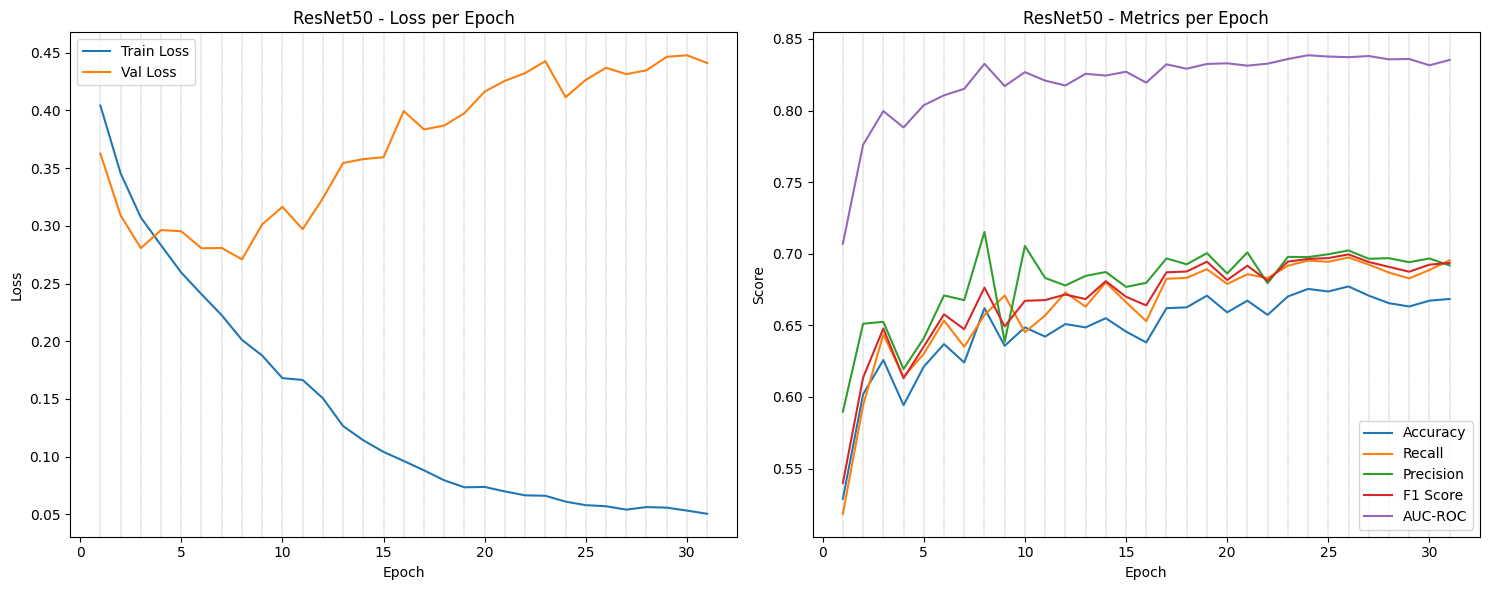

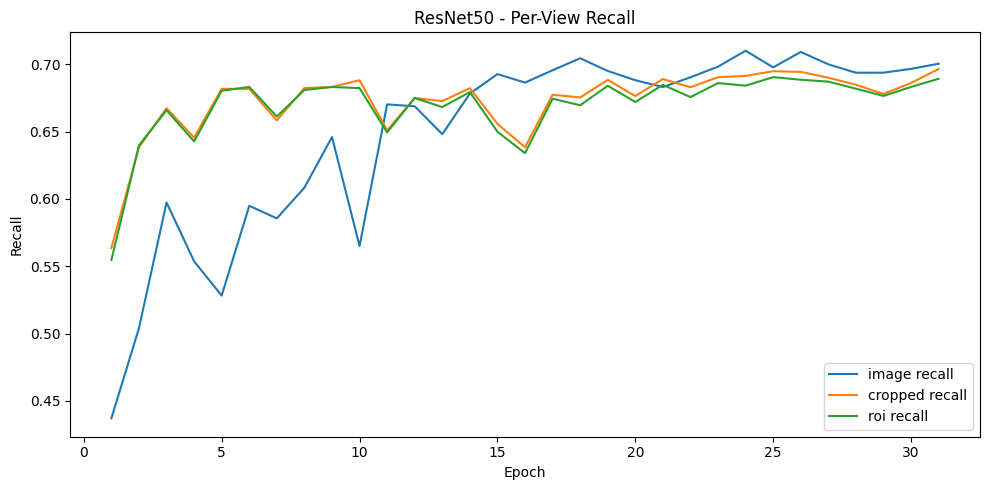

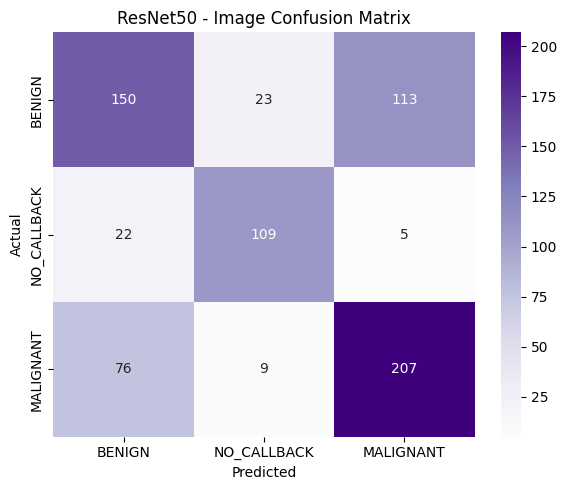

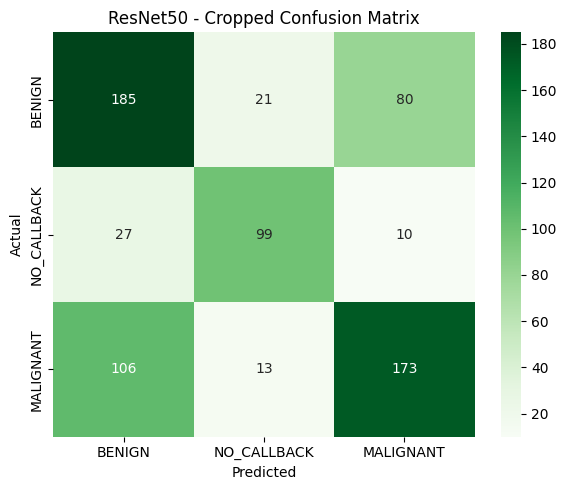

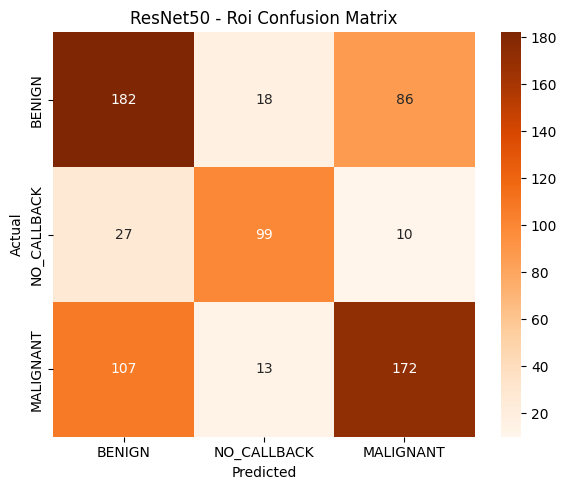

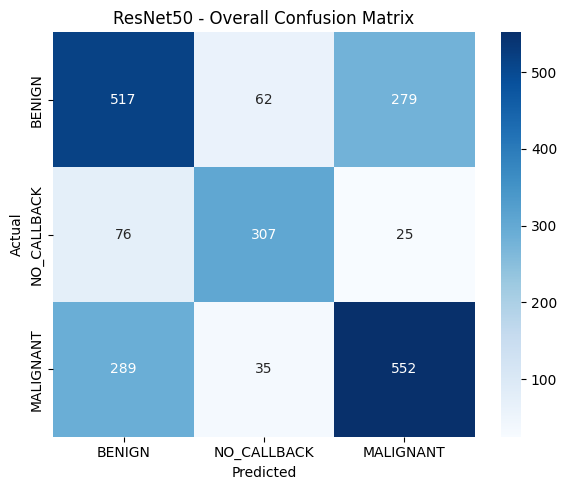


==== Training SVM ====
Performing GridSearchCV for SVM hyperparameter tuning...
Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best hyperparameters found:
{'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Validation Accuracy (CV): 0.6478
Classifier model saved to: D:\TFM\breast_cancer_detection\models\output\a141fb95-3ae4-4039-b425-585c3aeeb646\svm_a141fb95-3ae4-4039-b425-585c3aeeb646.pkl
Classifier model loaded from: D:\TFM\breast_cancer_detection\models\output\a141fb95-3ae4-4039-b425-585c3aeeb646\svm_a141fb95-3ae4-4039-b425-585c3aeeb646.pkl

==== Evaluation for SVM ====
Validation:
Accuracy: 0.5827
Precision: 0.5856
Recall: 0.6204
F1_score: 0.5978
Auc_roc: 0.7767
Test:
Accuracy: 0.5771
Precision: 0.5798
Recall: 0.6180
F1_score: 0.5917
Auc_roc: 0.7946

==== Training XGBoost ====
Performing GridSearchCV for XGBoost hyperparameter tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best hyperparameters found for XGBoost:
{'learning_rate': 0.1, 'max_depth': 5,

In [48]:
if SKIP_TRAINING:
    print(f"Skipping training for this run as SKIP_TRAINING is {SKIP_TRAINING}")
else:
    for model_name, strategy in strategies.items():
        print(f"\n==== Training {model_name} ====")
    
        if isinstance(strategy, BaseModel):
            config = strategy.config
            train_transform = strategy.get_transforms(train=True)
            eval_transform = strategy.get_transforms(train=False)
        else:
            config = None
            train_transform = eval_transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5], std=[0.5])
            ])
    
        train_dataset = CBISDDSMDataset("train.parquet", transform=train_transform, multi_view=True, images_base_path=IMAGES_ABS_PATH)
        val_dataset   = CBISDDSMDataset("val.parquet", transform=eval_transform, multi_view=True, images_base_path=IMAGES_ABS_PATH)
        test_dataset  = CBISDDSMDataset("test.parquet", transform=eval_transform, multi_view=True, images_base_path=IMAGES_ABS_PATH)
    
        train_loader = DataLoader(train_dataset, batch_size=70, shuffle=True, num_workers=8, pin_memory=True)
        val_loader   = DataLoader(val_dataset, batch_size=70, shuffle=False, num_workers=8, pin_memory=True)
        test_loader  = DataLoader(test_dataset, batch_size=70, shuffle=False, num_workers=8, pin_memory=True)

        run_dir = os.path.join(MODELS_OUTPUT_PATH, correlation_id)
        os.makedirs(run_dir, exist_ok=True)
    
        if isinstance(strategy, BaseModel):
            model = strategy.get_model().to(device)
            optimizer = Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
            scheduler = ReduceLROnPlateau(optimizer, mode="max", factor=0.5, patience=config.scheduler_patience)
            criterion = FocalLoss(gamma=config.gamma)
            early_stopping = EarlyStopping(
                monitor="val_recall",
                mode="max",
                patience=config.early_stop_patience,
                delta=0.001
            )
    
            trainer = Trainer(
                model=model,
                device=device,
                optimizer=optimizer,
                criterion=criterion,
                scheduler=scheduler,
                early_stopping=early_stopping
            )
    
            trainer.fit(train_loader, val_loader, epochs=50)
    
            model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pth")
            trainer.save_best_model(model_path)
            trainer.load_model(model_path)
    
            acc, loss, recall, precision, f1, auc, per_view_metrics, per_view_predictions = trainer.evaluate(test_loader)
    
            results.append({
                "model": model_name,
                "accuracy": acc,
                "recall": recall,
                "precision": precision,
                "f1_score": f1,
                "auc_roc": auc
            })
    
            for view, metrics in per_view_metrics.items():
                results.append({
                    "model": model_name,
                    "view": view,
                    "accuracy": metrics["accuracy"],
                    "recall": metrics["recall"],
                    "precision": metrics["precision"],
                    "f1_score": metrics["f1"],
                    "auc_roc": metrics["auc"]
                })
    
            history_path = os.path.join(MODELS_LOGS_OUTPUT_PATH, f"{model_name.lower()}_{correlation_id}_history.csv")
            save_training_history_to_csv(trainer.get_history(), history_path)
            plot_training_history(trainer.get_history(), model_name=model_name)
    
            for view, pred_data in per_view_predictions.items():
                plot_confusion_matrix(
                    y_true=pred_data["y_true"],
                    y_pred=pred_data["y_pred"],
                    class_names=["BENIGN", "NO_CALLBACK", "MALIGNANT"],
                    title=f"{model_name} - {view.capitalize()} Confusion Matrix",
                    cmap=COLORMAPS.get(view.lower(), "Greys")
                )
    
            y_true, y_pred = [], []
            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    images = images.to(device)
                    preds = model(images).argmax(dim=1)
                    y_pred.extend(preds.cpu().numpy())
                    y_true.extend(labels.numpy())
    
            plot_confusion_matrix(
                y_true=y_true,
                y_pred=y_pred,
                class_names=["BENIGN", "NO_CALLBACK", "MALIGNANT"],
                title=f"{model_name} - Overall Confusion Matrix",
                cmap="Blues"
            )
    
        elif isinstance(strategy, BaseClassifier): 
            strategy.fit(train_df)
        
            model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pkl")
            strategy.save_model(model_path)
        
            strategy.load_model(model_path)
        
            # Evaluate on test and validation sets
            test_metrics = strategy.evaluate(test_df)
            val_metrics = strategy.evaluate(val_df)
            
            results.append({
                "model": model_name,
                "split": "test",
                "accuracy": test_metrics["accuracy"],
                "recall": test_metrics["recall"],
                "precision": test_metrics["precision"],
                "f1_score": test_metrics["f1_score"],
                "auc_roc": test_metrics["auc_roc"],
                "view": "image"
            })
            
            print(f"\n==== Evaluation for {model_name} ====")
            print("Validation:")
            for metric, value in val_metrics.items():
                print(f"{metric.capitalize()}: {value:.4f}")
            print("Test:")
            for metric, value in test_metrics.items():
                print(f"{metric.capitalize()}: {value:.4f}")

Saved results to D:\TFM\breast_cancer_detection\models\logs\a141fb95-3ae4-4039-b425-585c3aeeb646\summary_test_results_a141fb95-3ae4-4039-b425-585c3aeeb646.csv


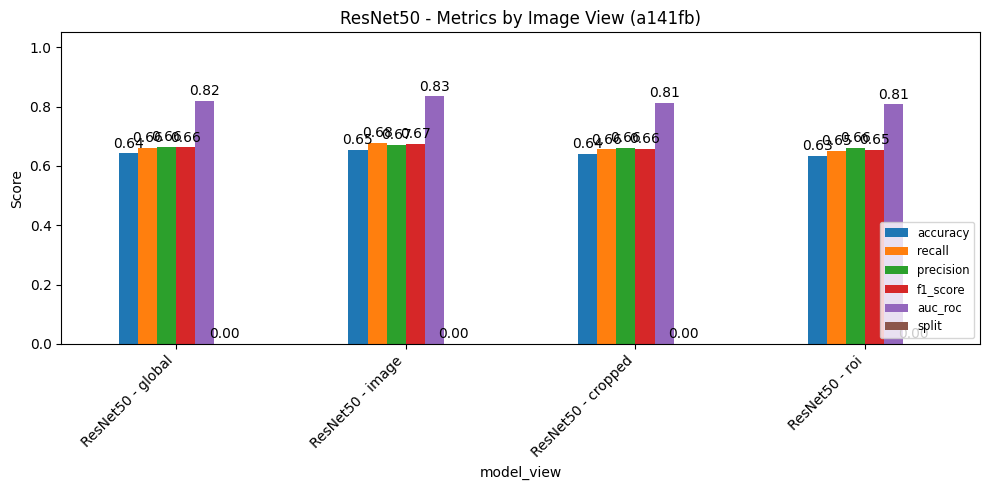

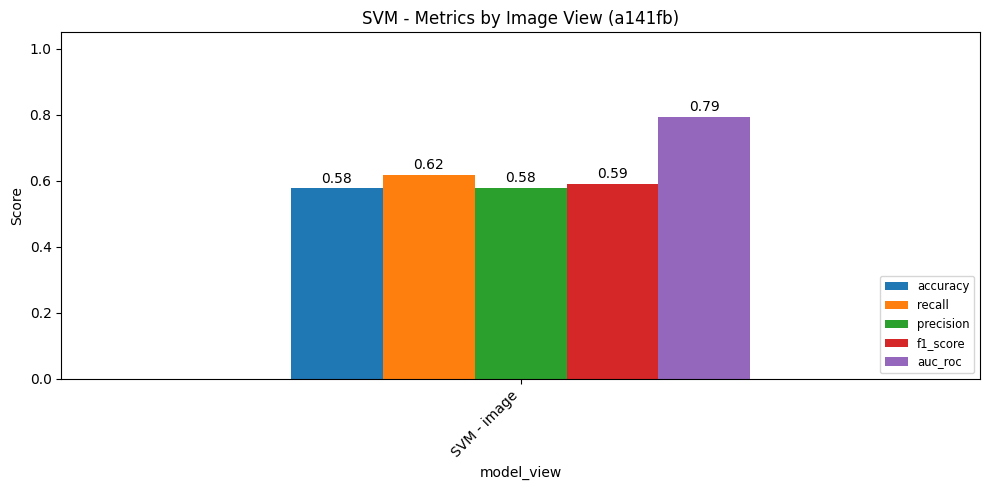

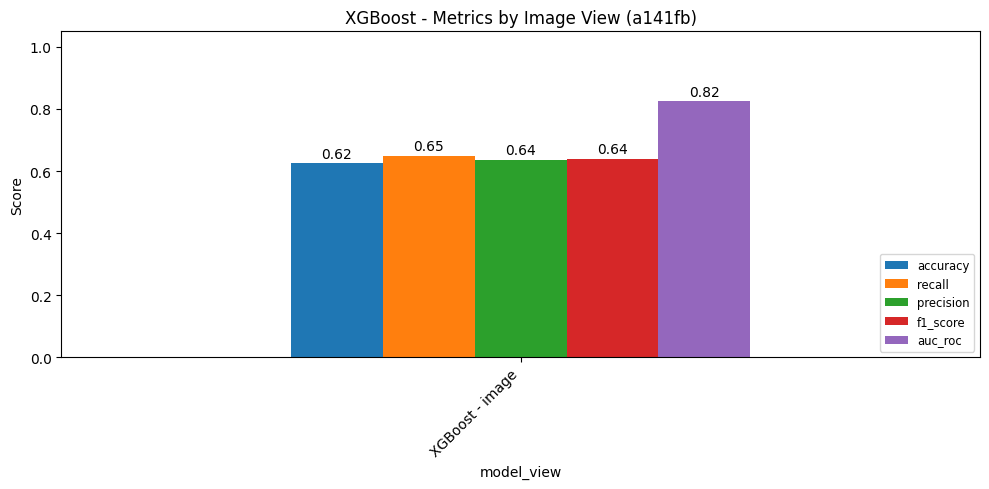

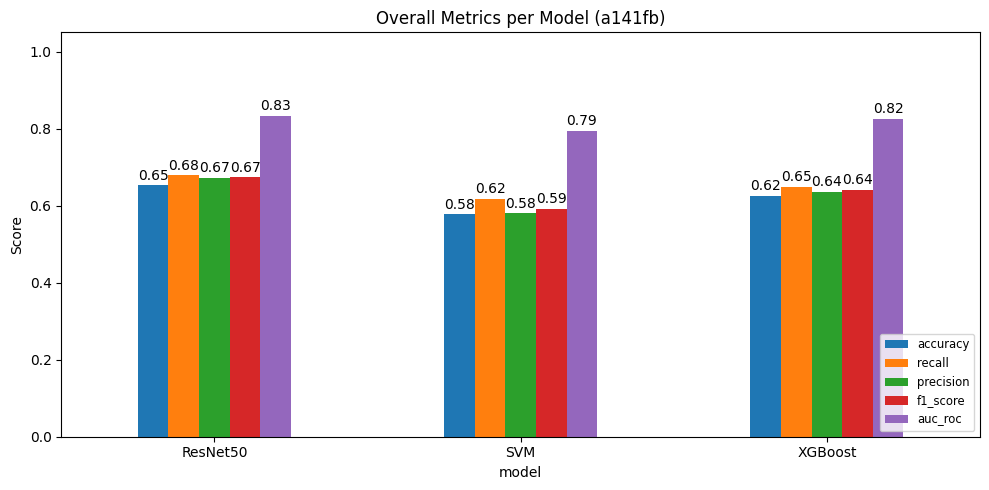

In [49]:
if SKIP_TRAINING:
    print(f"Skipping training for this run as SKIP_TRAINING is {SKIP_TRAINING}")
else:
    import pandas as pd
    import matplotlib.pyplot as plt
    import os
    
    results_df = pd.DataFrame(results)

    save_path = os.path.join(MODELS_LOGS_OUTPUT_PATH, correlation_id)
    os.makedirs(save_path, exist_ok=True)
    
    raw_path = os.path.join(save_path, f"summary_test_results_{correlation_id}.csv")
    results_df.to_csv(raw_path, index=False)
    print(f"Saved results to {raw_path}")
    
    # Fill view = "global" where missing
    results_df["view"] = results_df["view"].fillna("global")
    results_df["model_view"] = results_df["model"] + " - " + results_df["view"]
    results_df.set_index("model_view", inplace=True)
    
    view_df = results_df.copy()
    
    # Plot
    for model in view_df["model"].unique():
        model_data = view_df[view_df["model"] == model]
        title = f"{model} - Metrics by Image View ({correlation_id[:6]})"
        
        ax = model_data.drop(columns=["model"]).plot(
            kind="bar", 
            figsize=(10, 5),
            title=title
        )
        plt.ylabel("Score")
        plt.xticks(rotation=45, ha="right")
        plt.ylim(0, 1.05)
        plt.legend(loc="lower right", fontsize="small")
        plt.tight_layout()
    
        for container in ax.containers:
            ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)
    
        plt.show()
    
    overall_df = results_df[results_df.index.str.endswith("image")].copy()
    overall_df.index = overall_df["model"]  # Replace index with model name
    overall_df = overall_df.drop(columns=["model", "view"])
    
    ax = overall_df.plot(kind="bar", figsize=(10, 5))
    plt.title(f"Overall Metrics per Model ({correlation_id[:6]})")
    plt.ylabel("Score")
    plt.xticks(rotation=0)
    plt.ylim(0, 1.05)
    plt.legend(loc="lower right", fontsize="small")
    plt.tight_layout()
    
    for container in ax.containers:
        ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)
    
    plt.show()

---
# Comparación entre experimentos

Veamos el progreso entre nuestros experimentos.

In [ ]:
if SKIP_TRAINING:
    print(f"Skipping training for this run as SKIP_TRAINING is {SKIP_TRAINING}")
else:
    import os
    import pandas as pd
    import matplotlib.pyplot as plt
    from datetime import datetime
    
    def plot_multiple_experiment_results(exp_ids: list[str], logs_path: str):
        all_results = []
    
        for exp_id in exp_ids:
            file_path = os.path.join(logs_path, f"summary_test_results_{exp_id}.csv")
    
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
    
            # Read file and creation date
            df = pd.read_csv(file_path)
            creation_time = os.path.getctime(file_path)
            creation_date = datetime.fromtimestamp(creation_time).strftime("%Y-%m-%d")

            print(file_path)

            print(df.columns)
            
            # Add experiment label
            experiment_label = f"{exp_id[:6]} ({creation_date})"
            df["experiment"] = experiment_label
            df["view"] = df["view"].fillna("global")
            all_results.append(df)
    
        if not all_results:
            print("No valid result files found.")
            return
    
        combined_df = pd.concat(all_results, ignore_index=True)
    
        metric_cols = ["accuracy", "recall", "precision", "f1_score"]
        view_order = ["global", "image", "cropped", "roi"]
    
        for model in combined_df["model"].unique():
            model_df = combined_df[combined_df["model"] == model].copy()
    
            for view in view_order:
                view_df = model_df[model_df["view"] == view].copy()
                if view_df.empty:
                    continue
    
                # Build DataFrame: index = experiment, columns = metric
                plot_df = view_df.set_index("experiment")[metric_cols]
    
                ax = plot_df.plot(kind="bar", figsize=(10, 5))
                plt.title(f"{model} - {view.capitalize()} Metrics per Experiment")
                plt.ylabel(view)
                plt.xticks(rotation=0)
                plt.ylim(0, 1.05)
                plt.legend(title="Metric", fontsize="small", loc="lower right")
                plt.tight_layout()
    
                for container in ax.containers:
                    ax.bar_label(container, fmt="%.2f", label_type="edge", padding=2)
    
                plt.show()
    
    experiment_ids = ['d93e0a9e-4d32-459f-81bf-9f0fb9ac156f', correlation_id]
    plot_multiple_experiment_results(experiment_ids, MODELS_LOGS_OUTPUT_PATH)

# Inferencias

A continuación, se cargan los modelos entrenados previamente para poder obtener predicciones sobre conjuntos de datos mediante el módilo de inferencias (Inference) implementado en el proyecto.

## Inferencia uno a uno

Se testea el módulo de inferencia usando el método que recibe una imagen como entrada.

In [50]:
model_name="ResNet50"

In [51]:
import os
import torch
from inference.cnn_predictor import CNNPredictor
from utils.dicom import load_image
from models.resnet import ResNetModel
from models.efficientnet import EfficientNetModel
from models.mobilenet import MobileNetModel


label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
if not SKIP_TRAINING:
    model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pth")
else:
    correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0"
    model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"resnet50_{correlation_id}.pth")

strategy = strategies[model_name]

predictor = CNNPredictor(strategy, model_path, label_list=label_list)

image_path = r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009\1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992\1-1.dcm"
cropped_path = r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942\1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515\1-1.dcm"
roi_path = r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942\1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515\1-2.dcm"

mal_image_path = r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515\1-1.dcm"
mal_cropped_path = r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\1-1.dcm"
mal_roi_path = r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\1-2.dcm"

image = load_image(image_path)

result = predictor.predict(image)
print(f"Predicted class: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Probabilities: {result['all_probs']}")

Predicted class: 1
Confidence: 0.9350
Probabilities: [0.014 0.935 0.051]


In [52]:
from inference.classifier_predictor import ClassifierPredictor

# Load strategy and model
strategy = strategies["SVM"]

if not SKIP_TRAINING:
    model_path = os.path.join(run_dir, f"svm_{correlation_id}.pkl")
else:
    correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0"
    model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"svm_{correlation_id}.pkl")

predictor = ClassifierPredictor(strategy, model_path)

# Load image (PNG, JPG, or preprocessed DICOM)
image = load_image(image_path)

# Predict
result = predictor.predict(image)

print(f"Predicted class: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Probabilities: {result['all_probs']}")

Predicted class: 1
Confidence: 0.7400
Probabilities: [0.148 0.74  0.112]


In [53]:
from inference.classifier_predictor import ClassifierPredictor

# Load strategy and model
strategy = strategies["XGBoost"]

if not SKIP_TRAINING:
    model_path = os.path.join(run_dir, f"xgboost_{correlation_id}.pkl")
else:
    correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0"
    model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"xgboost_{correlation_id}.pkl")

predictor = ClassifierPredictor(strategy, model_path)

# Load image (PNG, JPG, or preprocessed DICOM)
image = load_image(image_path)

# Predict
result = predictor.predict(image)

print(f"Predicted class: {result['prediction']}")
print(f"Confidence: {result['confidence']:.4f}")
print(f"Probabilities: {result['all_probs']}")

Predicted class: 1
Confidence: 0.7290
Probabilities: [0.117 0.729 0.154]


---

## Inferencia uno a uno (directorio)

Se testea el módulo de inferencia usando el método que recibe la dirección del archivo como entrada.

In [ ]:
import os
from inference.cnn_predictor import CNNPredictor

label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
strategy = strategies[model_name]

if not SKIP_TRAINING:
    model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pth")
else:
    correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0"
    model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"resnet50_{correlation_id}.pth")

predictor = CNNPredictor(strategy, model_path, label_list=label_list)

benign_dict = {
    'image': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009\1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992\1-1.dcm",
    'cropped': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942\1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515\1-1.dcm",
    'roi': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.161465562211359959230647609981488894942\1.3.6.1.4.1.9590.100.1.2.419081637812053404913157930753972718515\1-2.dcm"
}

malignant_dict = {
    'image': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515\1-1.dcm",
    'cropped': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\1-1.dcm",
    'roi': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC_1\1.3.6.1.4.1.9590.100.1.2.108268213011361124203859148071588939106\1.3.6.1.4.1.9590.100.1.2.296736403313792599626368780122205399650\1-2.dcm"
}

for k, v in benign_dict.items():
    result = predictor.predict_from_path(v)
    print(f"[Benign {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")

for k, v in malignant_dict.items():
    result = predictor.predict_from_path(v)
    print(f"[Malignant {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")

In [ ]:
import os
from inference.classifier_predictor import ClassifierPredictor


label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
strategy = strategies["SVM"]

if not SKIP_TRAINING:
    model_path = os.path.join(run_dir, f"svm_{correlation_id}.pkl")
else:
    correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0"
    model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"svm_{correlation_id}.pkl")

predictor = ClassifierPredictor(strategy, model_path, label_list)

benign_dict = {
    'image': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009\1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992\1-1.dcm",
}

malignant_dict = {
    'image': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515\1-1.dcm",
}

# Run predictions
for k, v in benign_dict.items():
    result = predictor.predict_from_path(v)
    print(f"[Benign {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")

for k, v in malignant_dict.items():
    result = predictor.predict_from_path(v)
    print(f"[Malignant {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")


In [ ]:
import os
from inference.classifier_predictor import ClassifierPredictor


label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
strategy = strategies["XGBoost"]

if not SKIP_TRAINING:
    model_path = os.path.join(run_dir, f"xgboost_{correlation_id}.pkl")
else:
    correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0"
    model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"xgboost_{correlation_id}.pkl")

predictor = ClassifierPredictor(strategy, model_path, label_list)

benign_dict = {
    'image': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Calc-Test_P_00038_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.85935434310203356712688695661986996009\1.3.6.1.4.1.9590.100.1.2.374115997511889073021386151921807063992\1-1.dcm",
}

malignant_dict = {
    'image': r"D:\TFM\breast_cancer_detection\data\CBIS-DDSM\CBIS-DDSM\Mass-Training_P_00001_LEFT_CC\1.3.6.1.4.1.9590.100.1.2.422112722213189649807611434612228974994\1.3.6.1.4.1.9590.100.1.2.342386194811267636608694132590482924515\1-1.dcm",
}

# Run predictions
for k, v in benign_dict.items():
    result = predictor.predict_from_path(v)
    print(f"[Benign {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")

for k, v in malignant_dict.items():
    result = predictor.predict_from_path(v)
    print(f"[Malignant {k}] Predicted: {result['prediction']} ({result['class_label']}) | Confidence: {result['confidence']:.2f}")

---

## Inferencia por lotes (directorio)
Se testea el módulo de inferencia usando el método que recibe la dirección de una carpeta como entrada, ejecuntando la inferencia en el primer nivel del directorio.

In [56]:
import os
from inference.cnn_predictor import CNNPredictor

label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
cnn_names = ["ResNet50", "EfficientNetB0", "MobileNetV3"]

for model_name in cnn_names:
    print(f"\n==== Bach inference for {model_name} ====")
    strategy = strategies[model_name]
    
    if not SKIP_TRAINING:
        model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pth")
    else:
        correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0" # Known working experiment uuid
        model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"{model_name}_{correlation_id}.pth")
    
    predictor = CNNPredictor(strategy, model_path, label_list=label_list)
    
    external_studies_path = r"D:\TFM\breast_cancer_detection\data\inbreast_subset"
    
    results = predictor.predict_directory(
        dir_path=external_studies_path,
        correlation_id=correlation_id,
        output_path=INFERENCE_OUTPUT,
        output_file_name=f"{model_name}_inference.csv"
    )
    
    for r in results:
        print(f"{r['filename']}: {r['prediction']} ({r['class_label']}) — {r['confidence']:.2f}")



==== Bach inference for ResNet50 ====
[INFO] Results saved to D:\TFM\breast_cancer_detection\output\a141fb95-3ae4-4039-b425-585c3aeeb646\ResNet50_inference_20250606_201539.csv
22678622_61b13c59bcba149e_MG_R_CC_ANON.dcm: 2 (MALIGNANT) — 0.64
22678670_61b13c59bcba149e_MG_R_ML_ANON.dcm: 1 (BENIGN_WITHOUT_CALLBACK) — 0.93
53581406_b231a8ba4dd4214f_MG_R_ML_ANON.dcm: 1 (BENIGN_WITHOUT_CALLBACK) — 0.84
53581460_b231a8ba4dd4214f_MG_R_CC_ANON.dcm: 1 (BENIGN_WITHOUT_CALLBACK) — 0.96

==== Bach inference for EfficientNetB0 ====


KeyError: 'EfficientNetB0'

In [57]:
import os
from inference.classifier_predictor import ClassifierPredictor

label_list = [label for label, idx in sorted(LABEL_MAP.items(), key=lambda x: x[1])]
classifier_names = ["SVM", "XGBoost"]

for model_name in classifier_names:
    print(f"\n==== Bach inference for {model_name} ====")
    strategy = strategies[model_name]

    if not SKIP_TRAINING:
        model_path = os.path.join(run_dir, f"svm_{correlation_id}.pkl")
    else:
        correlation_id = "5d6e94d5-c3ef-46dd-913b-47101052a0f0" # Known working experiment uuid
        model_path = os.path.join(MODELS_OUTPUT_PATH, correlation_id, f"svm_{correlation_id}.pkl")
    
    predictor = ClassifierPredictor(strategy, model_path, label_list=label_list)
    
    external_studies_path = r"D:\TFM\breast_cancer_detection\data\busi_subset"
    
    results = predictor.predict_directory(
        dir_path=external_studies_path,
        correlation_id=correlation_id,
        output_path=INFERENCE_OUTPUT,
        output_file_name=f"{model_name}_inference.csv"
    )
    
    for r in results:
        print(f"{r['filename']}: {r['prediction']} ({r['class_label']}) — {r['confidence']:.2f}")


==== Bach inference for SVM ====
[INFO] Results saved to D:\TFM\breast_cancer_detection\output\a141fb95-3ae4-4039-b425-585c3aeeb646\SVM_inference_20250606_201555.csv
benign (1).png: 2 (MALIGNANT) — 0.62
benign (1)_mask.png: 2 (MALIGNANT) — 0.62
benign (2).png: 2 (MALIGNANT) — 0.62
benign (2)_mask.png: 2 (MALIGNANT) — 0.62
benign (3).png: 2 (MALIGNANT) — 0.62
benign (3)_mask.png: 2 (MALIGNANT) — 0.62
benign (4).png: 2 (MALIGNANT) — 0.62
benign (4)_mask.png: 2 (MALIGNANT) — 0.62
benign (4)_mask_1.png: 2 (MALIGNANT) — 0.62
malignant (1).png: 2 (MALIGNANT) — 0.62
malignant (1)_mask.png: 2 (MALIGNANT) — 0.62
malignant (2).png: 2 (MALIGNANT) — 0.62
malignant (2)_mask.png: 2 (MALIGNANT) — 0.62
malignant (3).png: 2 (MALIGNANT) — 0.62
malignant (3)_mask.png: 2 (MALIGNANT) — 0.62
malignant (4).png: 2 (MALIGNANT) — 0.62
malignant (4)_mask.png: 2 (MALIGNANT) — 0.62
malignant (5).png: 2 (MALIGNANT) — 0.62
normal (1).png: 2 (MALIGNANT) — 0.62
normal (1)_mask.png: 2 (MALIGNANT) — 0.62
normal (2).png

---

# Explicabilidad

En el siguiente apartado, se agrega explicabilidad a las predicciones realizadas por un modelo ya entrenado anteriormente con el fin de poder visualizar en qué areas de las imágenes se centra un modelo para realizar una predicción.

In [59]:
model_name = "ResNet50"

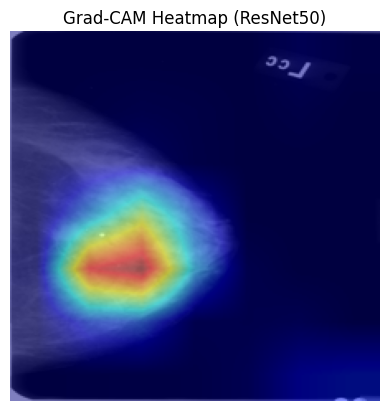

In [60]:
from inference.gradcam_explainer import GradCAMExplainer
import matplotlib.pyplot as plt

model_path = os.path.join(run_dir, f"{model_name.lower()}_{correlation_id}.pth")
strategy = strategies[model_name]
predictor = CNNPredictor(strategy, model_path, label_list=label_list)

explainer = GradCAMExplainer(predictor=predictor)

image = load_image(mal_image_path)

cam_image = explainer.explain(image)

plt.imshow(cam_image)
plt.axis('off')
plt.title(f"Grad-CAM Heatmap ({model_name})")
plt.show()